In [33]:
import pandas as pd; import numpy as np ; import warnings; warnings.filterwarnings('ignore') ;import seaborn as sns; 
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import optuna; optuna.logging.set_verbosity(optuna.logging.ERROR)
import shap ; from sklearn.mixture import GaussianMixture
from IPython.display import Image ; from IPython.display import display, HTML
import base64 ; from io import BytesIO ; import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False 
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_prop = fm.FontProperties(fname=font_path)
import scipy.stats as stats;import time
from sklearn.metrics import average_precision_score,precision_recall_curve

In [34]:
df = pd.read_csv(r'C:\Users\rla\산불논문\힘들어죽겠다진짜.csv',encoding='cp949');df = df.drop('date',axis=1);df.head(1)

,Location,Temp,WindSpd,RH,VaporP,DewPt,Pressure,GroundT,Rain,CumRain,WinDir,Wildfire,Month,Day,Hour
0,Seoul,27.6,1.7,42.0,15.5,13.5,1002.9,44.3,0.0,0.0,동,1,6,28,11


In [11]:
start = time.time()
# 데이터 전처리
df.월 = df.월.astype('category')
df.일 = df.일.astype('category')
df.시 = df.시.astype('category') 
df.풍향 = df.풍향.astype('category')
df.지점명 = df.지점명.astype('category')

# 데이터 분할
pos = df[df['산불'] == 1]
neg = df[df['산불'] == 0]

# 훈련 데이터
tr_pos = pos.sample(n=4871, random_state=1)
tr_neg = neg.sample(n=4871, random_state=1)

# 테스트 데이터 (test1만)
pos = pos.drop(tr_pos.index)
neg = neg.drop(tr_neg.index)
t1_pos = pos.sample(n=100, random_state=1)
t1_neg = neg.sample(n=100000, random_state=1)

# 훈련/테스트 세트 생성
train = pd.concat([tr_pos, tr_neg]).sample(frac=1, random_state=1)
test1 = pd.concat([t1_pos, t1_neg]).sample(frac=1, random_state=1)
 
xtr = train.drop('산불', axis=1)
ytr = train['산불']
xte = test1.drop('산불', axis=1)
yte = test1['산불']

cat_feat = ['풍향', '시', '월','일','지점명']

# 하이퍼파라미터 최적화
def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 6, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 1.0, log=True),

        'iterations': trial.suggest_int('iterations', 1000, 2000),
        'loss_function': 'Logloss',
        'verbose': 0,
        'thread_count': 6,  # CatBoost용 6스레드
        'cat_features': cat_feat
    }
    params['train_dir'] = f'catboost_info_{trial.number}'
    model = CatBoostClassifier(**params)
    model.fit(xtr, ytr)
    y_pred_bin = (model.predict_proba(xtr)[:, 1] >= 0.7).astype(int)
    return f1_score(ytr, y_pred_bin)

# Optuna 최적화 (4스레드)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, n_jobs=2)

# 최적 모델 학습
best = study.best_params
best.update({
    'loss_function': 'Logloss',
    'verbose': 0,
    'thread_count': 8,  # CatBoost용 8스레드
    'cat_features': cat_feat
})

model = CatBoostClassifier(**best)
model.fit(xtr, ytr)

# 결과 출력
print("="*50)
print("최적 하이퍼파라미터")
print("="*50)
for param, value in study.best_params.items():
    print(f"{param}: {value}")

thresh = 0.7

# 훈련 데이터 분류 리포트
print("\n=== Training Classification Report ===")
print(classification_report(
    ytr,
    (model.predict_proba(xtr)[:,1] >= thresh).astype(int)
))

# 테스트1 분류 리포트
print("\n=== TEST1 Classification Report ===")
print(classification_report(
    yte,
    (model.predict_proba(xte)[:,1] >= thresh).astype(int)
))

# SHAP 분석
n_shap = min(5000, len(xtr))
rng = np.random.RandomState(1)
idx = rng.choice(xtr.index, size=n_shap, replace=False)

X_shap = xtr.loc[idx]
# ytr가 Series면 .loc, ndarray면 인덱스 정수 위치로 접근
y_shap = ytr.loc[idx] if hasattr(ytr, "loc") else ytr[xtr.index.get_indexer(idx)]

# CatBoost 전용 Pool 
pool_shap = pool(X_shap, y_shap, cat_features=cat_feat)

# CatBoost 네이티브 SHAP (마지막 열이 base value)
shap_vals_full = model.get_feature_importance(
    type='ShapValues',
    data=pool_shap
)
shap_vals = shap_vals_full[:, :-1]

shap.summary_plot(shap_vals, X_shap, show=False)
plt.title('훈련 데이터 특성 중요도 (SHAP, sampled)')
plt.show()

최적 하이퍼파라미터
depth: 8
learning_rate: 0.0843054703061494
l2_leaf_reg: 0.26697122121647576
iterations: 1877

=== Training Classification Report ===
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      4871
           1       0.97      0.96      0.97      4871

    accuracy                           0.97      9742
   macro avg       0.97      0.97      0.97      9742
weighted avg       0.97      0.97      0.97      9742


=== TEST1 Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.88      0.94    100000
           1       0.01      0.76      0.01       100

    accuracy                           0.88    100100
   macro avg       0.50      0.82      0.47    100100
weighted avg       1.00      0.88      0.94    100100



NameError: name 'Pool' is not defined

최적 하이퍼파라미터
depth: 8
learning_rate: 0.07665425470714404
l2_leaf_reg: 0.3494747400702159
iterations: 1973

=== Training Classification Report ===
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4871
           1       0.97      0.95      0.96      4871

    accuracy                           0.96      9742
   macro avg       0.96      0.96      0.96      9742
weighted avg       0.96      0.96      0.96      9742


=== TEST1 Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.88      0.94    100000
           1       0.01      0.76      0.01       100

    accuracy                           0.88    100100
   macro avg       0.50      0.82      0.48    100100
weighted avg       1.00      0.88      0.94    100100



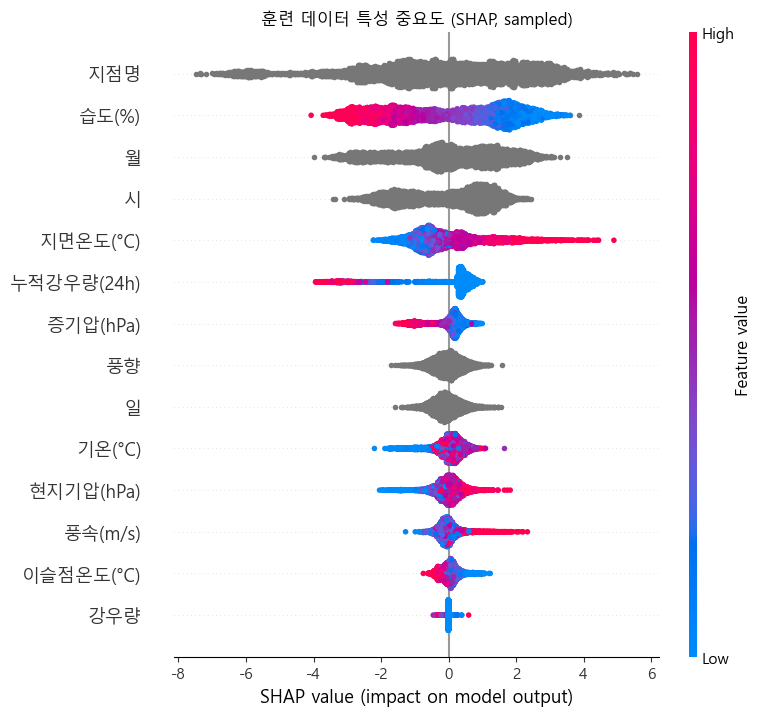

In [15]:
# 필요한 import 추가
from catboost import CatBoostClassifier, Pool
import optuna
import shap

start = time.time()

# 데이터 전처리
df.월 = df.월.astype('category')
df.일 = df.일.astype('category')
df.시 = df.시.astype('category') 
df.풍향 = df.풍향.astype('category')
df.지점명 = df.지점명.astype('category')

# 데이터 분할
pos = df[df['산불'] == 1]
neg = df[df['산불'] == 0]

# 훈련 데이터
tr_pos = pos.sample(n=4871, random_state=1)
tr_neg = neg.sample(n=4871, random_state=1)

# 테스트 데이터 (test1만)
pos = pos.drop(tr_pos.index)
neg = neg.drop(tr_neg.index)
t1_pos = pos.sample(n=100, random_state=1)
t1_neg = neg.sample(n=100000, random_state=1)

# 훈련/테스트 세트 생성
train = pd.concat([tr_pos, tr_neg]).sample(frac=1, random_state=1)
test1 = pd.concat([t1_pos, t1_neg]).sample(frac=1, random_state=1)
 
xtr = train.drop('산불', axis=1)
ytr = train['산불']
xte = test1.drop('산불', axis=1)
yte = test1['산불']
cat_feat = ['풍향', '시', '월','일','지점명']

# 하이퍼파라미터 최적화
def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 6, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 1.0, log=True),
        'iterations': trial.suggest_int('iterations', 1000, 2000),
        'loss_function': 'Logloss',
        'verbose': 0,
        'thread_count': 6,
        'cat_features': cat_feat,
        'train_dir': f'catboost_info_{trial.number}'  # 여기로 이동
    }
    
    model = CatBoostClassifier(**params)
    model.fit(xtr, ytr)
    y_pred_bin = (model.predict_proba(xtr)[:, 1] >= 0.7).astype(int)
    return f1_score(ytr, y_pred_bin)

# Optuna 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, n_jobs=2)

# 최적 모델 학습
best = study.best_params
best.update({
    'loss_function': 'Logloss',
    'verbose': 0,
    'thread_count': 8,
    'cat_features': cat_feat
})

model = CatBoostClassifier(**best)
model.fit(xtr, ytr)

# 결과 출력
print("="*50)
print("최적 하이퍼파라미터")
print("="*50)
for param, value in study.best_params.items():
    print(f"{param}: {value}")

thresh = 0.7

# 훈련 데이터 분류 리포트
print("\n=== Training Classification Report ===")
print(classification_report(
    ytr,
    (model.predict_proba(xtr)[:,1] >= thresh).astype(int)
))

# 테스트1 분류 리포트
print("\n=== TEST1 Classification Report ===")
print(classification_report(
    yte,
    (model.predict_proba(xte)[:,1] >= thresh).astype(int)
))

# SHAP 분석
n_shap = min(5000, len(xtr))
rng = np.random.RandomState(1)
idx = rng.choice(xtr.index, size=n_shap, replace=False)
X_shap = xtr.loc[idx]
y_shap = ytr.loc[idx]

# Pool 생성 (대문자 P)
pool_shap = Pool(X_shap, y_shap, cat_features=cat_feat)

# CatBoost 네이티브 SHAP
shap_vals_full = model.get_feature_importance(
    type='ShapValues',
    data=pool_shap
)
shap_vals = shap_vals_full[:, :-1]

shap.summary_plot(shap_vals, X_shap, show=False)
plt.title('훈련 데이터 특성 중요도 (SHAP, sampled)')
plt.show()

=== AUPRC ===
Train AUPRC:  0.9943
Test1 AUPRC: 0.0227


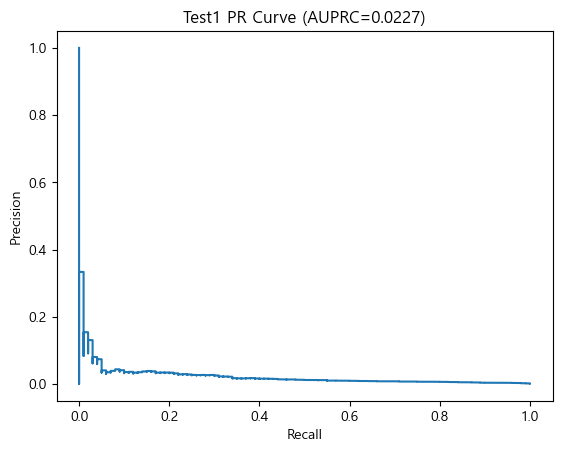

In [16]:
from sklearn.metrics import average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt

# 확률 예측
tr_proba = model.predict_proba(xtr)[:,1]
te_proba = model.predict_proba(xte)[:,1]

# AUPRC 계산
tr_ap = average_precision_score(ytr, tr_proba)
te_ap = average_precision_score(yte, te_proba)

print("=== AUPRC ===")
print(f"Train AUPRC:  {tr_ap:.4f}")
print(f"Test1 AUPRC: {te_ap:.4f}")

# PR 곡선 시각화 (옵션)
prec, rec, _ = precision_recall_curve(yte, te_proba)
plt.step(rec, prec, where='post')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Test1 PR Curve (AUPRC={te_ap:.4f})")
plt.show()


최적 하이퍼파라미터
depth: 10
learning_rate: 0.0649175891909655
l2_leaf_reg: 0.10010143876491477
iterations: 1302

=== Training Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.44      0.61      4871
           1       0.64      1.00      0.78      4871

    accuracy                           0.72      9742
   macro avg       0.82      0.72      0.70      9742
weighted avg       0.82      0.72      0.70      9742


=== TEST1 Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.44      0.61    100000
           1       0.00      1.00      0.00       100

    accuracy                           0.44    100100
   macro avg       0.50      0.72      0.31    100100
weighted avg       1.00      0.44      0.61    100100



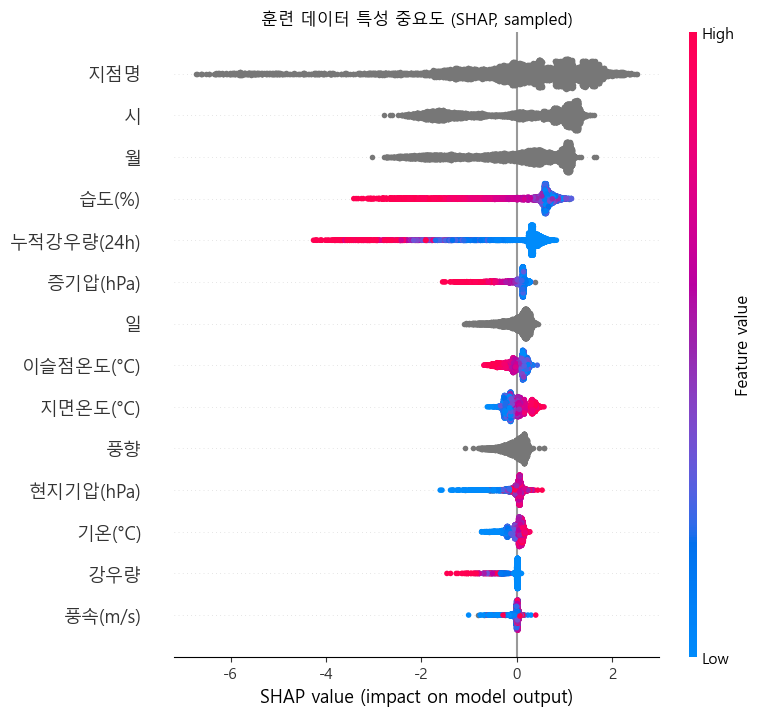

In [17]:
start = time.time()

# 데이터 전처리
df.월 = df.월.astype('category')
df.일 = df.일.astype('category')
df.시 = df.시.astype('category') 
df.풍향 = df.풍향.astype('category')
df.지점명 = df.지점명.astype('category')

# 데이터 분할
pos = df[df['산불'] == 1]
neg = df[df['산불'] == 0]

# 훈련 데이터
tr_pos = pos.sample(n=4871, random_state=1)
tr_neg = neg.sample(n=4871, random_state=1)

# 테스트 데이터 (test1만)
pos = pos.drop(tr_pos.index)
neg = neg.drop(tr_neg.index)
t1_pos = pos.sample(n=100, random_state=1)
t1_neg = neg.sample(n=100000, random_state=1)

# 훈련/테스트 세트 생성
train = pd.concat([tr_pos, tr_neg]).sample(frac=1, random_state=1)
test1 = pd.concat([t1_pos, t1_neg]).sample(frac=1, random_state=1)
 
xtr = train.drop('산불', axis=1)
ytr = train['산불']
xte = test1.drop('산불', axis=1)
yte = test1['산불']
cat_feat = ['풍향', '시', '월','일','지점명']

# 하이퍼파라미터 최적화
def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 6, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 1.0, log=True),
        'iterations': trial.suggest_int('iterations', 1000, 2000),
        'loss_function': 'Logloss',
        'verbose': 0,
        'thread_count': 6,
        'cat_features': cat_feat,
        'class_weights': [1, 500],
        'train_dir': f'catboost_info_{trial.number}'  # 여기로 이동
    }
    
    model = CatBoostClassifier(**params)
    model.fit(xtr, ytr)
    y_pred_bin = (model.predict_proba(xtr)[:, 1] >= 0.7).astype(int)
    return f1_score(ytr, y_pred_bin)

# Optuna 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, n_jobs=2)

# 최적 모델 학습
best = study.best_params
best.update({
    'loss_function': 'Logloss',
    'verbose': 0,
    'thread_count': 8,
    'cat_features': cat_feat,
    'class_weights': [1, 500],
})

model = CatBoostClassifier(**best)
model.fit(xtr, ytr)

# 결과 출력
print("="*50)
print("최적 하이퍼파라미터")
print("="*50)
for param, value in study.best_params.items():
    print(f"{param}: {value}")

thresh = 0.7

# 훈련 데이터 분류 리포트
print("\n=== Training Classification Report ===")
print(classification_report(
    ytr,
    (model.predict_proba(xtr)[:,1] >= thresh).astype(int)
))

# 테스트1 분류 리포트
print("\n=== TEST1 Classification Report ===")
print(classification_report(
    yte,
    (model.predict_proba(xte)[:,1] >= thresh).astype(int)
))

# SHAP 분석
n_shap = min(5000, len(xtr))
rng = np.random.RandomState(1)
idx = rng.choice(xtr.index, size=n_shap, replace=False)
X_shap = xtr.loc[idx]
y_shap = ytr.loc[idx]

# Pool 생성 (대문자 P)
pool_shap = Pool(X_shap, y_shap, cat_features=cat_feat)

# CatBoost 네이티브 SHAP
shap_vals_full = model.get_feature_importance(
    type='ShapValues',
    data=pool_shap
)
shap_vals = shap_vals_full[:, :-1]

shap.summary_plot(shap_vals, X_shap, show=False)
plt.title('훈련 데이터 특성 중요도 (SHAP, sampled)')
plt.show()

=== AUPRC ===
Train AUPRC:  0.9308
Test1 AUPRC: 0.0291


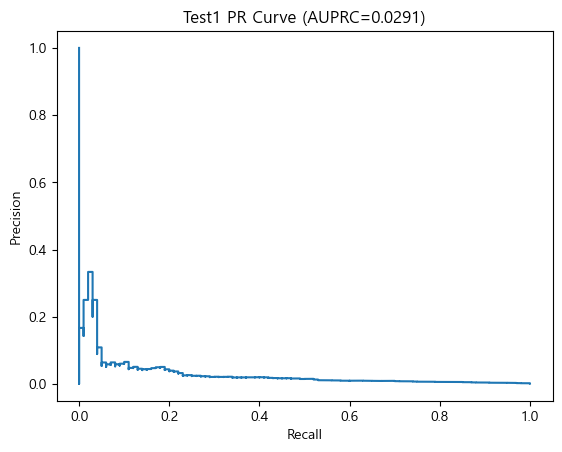

In [18]:
# 확률 예측
tr_proba = model.predict_proba(xtr)[:,1]
te_proba = model.predict_proba(xte)[:,1]

# AUPRC 계산
tr_ap = average_precision_score(ytr, tr_proba)
te_ap = average_precision_score(yte, te_proba)

print("=== AUPRC ===")
print(f"Train AUPRC:  {tr_ap:.4f}")
print(f"Test1 AUPRC: {te_ap:.4f}")

# PR 곡선 시각화 (옵션)
prec, rec, _ = precision_recall_curve(yte, te_proba)
plt.step(rec, prec, where='post')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Test1 PR Curve (AUPRC={te_ap:.4f})")
plt.show()


In [36]:


# 데이터 전처리
df.Month = df.Month.astype('category')
df.Day = df.Day.astype('category')
df.Hour = df.Hour.astype('category')
df.WinDir = df.WinDir.astype('category')
df.Location = df.Location.astype('category')

# 데이터 분할
pos = df[df['Wildfire'] == 1]
neg = df[df['Wildfire'] == 0]

# 훈련 데이터
tr_pos = pos.sample(n=4871, random_state=1)
tr_neg = neg.sample(n=4871, random_state=1)

# 테스트 데이터 (test1만)
pos = pos.drop(tr_pos.index)
neg = neg.drop(tr_neg.index)
t1_pos = pos.sample(n=100, random_state=1)
t1_neg = neg.sample(n=100000, random_state=1)

# 훈련/테스트 세트 생성
train = pd.concat([tr_pos, tr_neg]).sample(frac=1, random_state=1)
test1 = pd.concat([t1_pos, t1_neg]).sample(frac=1, random_state=1)
 
xtr = train.drop('Wildfire', axis=1)
ytr = train['Wildfire']
xte = test1.drop('Wildfire', axis=1)
yte = test1['Wildfire']
cat_feat = ['WinDir', 'Hour', 'Month', 'Day', 'Location'] 
# 하이퍼파라미터 최적화
best_params = {
    'depth': 6,
    'learning_rate': 0.08047664295808238,
    'l2_leaf_reg': 0.10188056276843381,
    'iterations': 1077,
    'loss_function': 'Logloss',
    'verbose': 0,
    'thread_count': 8,
    'cat_features': cat_feat,
    'class_weights': [1, 2000]
}
    
    model = CatBoostClassifier(**best_params)
    model.fit(xtr, ytr)
    y_pred_bin = (model.predict_proba(xtr)[:, 1] >= 0.7).astype(int)
    return f1_score(ytr, y_pred_bin)

# Optuna 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, n_jobs=2)

# 최적 모델 학습
best = study.best_params
best.update({
    'loss_function': 'Logloss',
    'verbose': 0,
    'thread_count': 8,
    'cat_features': cat_feat,
    'class_weights': [1, 2000]
})

model = CatBoostClassifier(**best)
model.fit(xtr, ytr)

# 결과 출력
print("="*50)
print("최적 하이퍼파라미터")
print("="*50)
for param, value in study.best_params.items():
    print(f"{param}: {value}")

thresh = 0.7

# 훈련 데이터 분류 리포트
print("\n=== Training Classification Report ===")
print(classification_report(
    ytr,
    (model.predict_proba(xtr)[:,1] >= thresh).astype(int)
))

# 테스트1 분류 리포트
print("\n=== TEST1 Classification Report ===")
print(classification_report(
    yte,
    (model.predict_proba(xte)[:,1] >= thresh).astype(int)
))

# SHAP 분석
n_shap = min(5000, len(xtr))
rng = np.random.RandomState(1)
idx = rng.choice(xtr.index, size=n_shap, replace=False)
X_shap = xtr.loc[idx]
y_shap = ytr.loc[idx]

# Pool 생성 (대문자 P)
pool_shap = Pool(X_shap, y_shap, cat_features=cat_feat)

# CatBoost 네이티브 SHAP
shap_vals_full = model.get_feature_importance(
    type='ShapValues',
    data=pool_shap
)
shap_vals = shap_vals_full[:, :-1]

shap.summary_plot(shap_vals, X_shap, show=False)
plt.title('훈련 데이터 특성 중요도 (SHAP, sampled)')
plt.show()

IndentationError: unexpected indent (393858761.py, line 46)


=== Training Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.15      0.27      4871
           1       0.54      1.00      0.70      4871

    accuracy                           0.58      9742
   macro avg       0.77      0.58      0.49      9742
weighted avg       0.77      0.58      0.49      9742


=== TEST1 Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.16      0.27    100000
           1       0.00      1.00      0.00       100

    accuracy                           0.16    100100
   macro avg       0.50      0.58      0.14    100100
weighted avg       1.00      0.16      0.27    100100



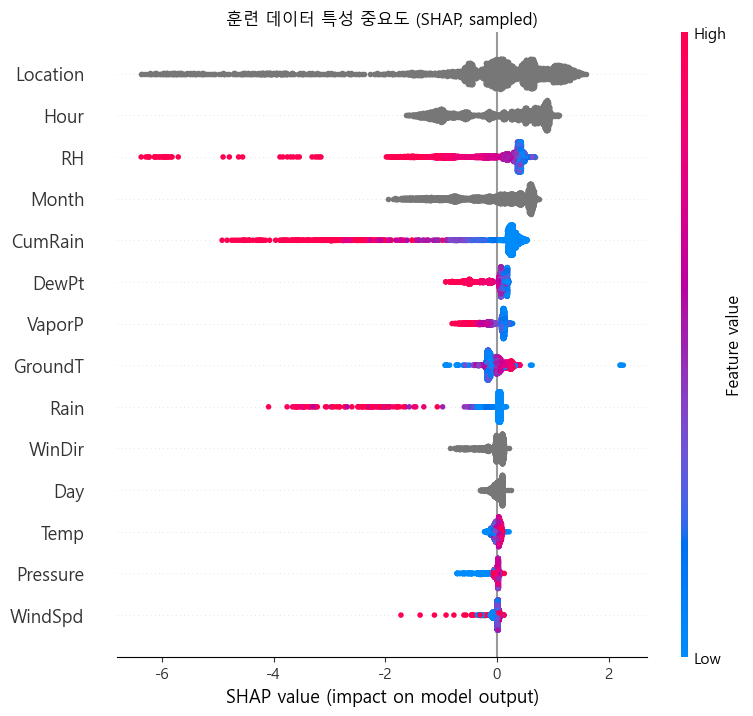

In [37]:
# 데이터 전처리
df.Month = df.Month.astype('category')
df.Day = df.Day.astype('category')
df.Hour = df.Hour.astype('category')
df.WinDir = df.WinDir.astype('category')
df.Location = df.Location.astype('category')

# 데이터 분할
pos = df[df['Wildfire'] == 1]
neg = df[df['Wildfire'] == 0]

# 훈련 데이터
tr_pos = pos.sample(n=4871, random_state=1)
tr_neg = neg.sample(n=4871, random_state=1)

# 테스트 데이터
pos = pos.drop(tr_pos.index)
neg = neg.drop(tr_neg.index)
t1_pos = pos.sample(n=100, random_state=1)
t1_neg = neg.sample(n=100000, random_state=1)

# 훈련/테스트 세트 생성
train = pd.concat([tr_pos, tr_neg]).sample(frac=1, random_state=1)
test1 = pd.concat([t1_pos, t1_neg]).sample(frac=1, random_state=1)

xtr = train.drop('Wildfire', axis=1)
ytr = train['Wildfire']
xte = test1.drop('Wildfire', axis=1)
yte = test1['Wildfire']
cat_feat = ['WinDir', 'Hour', 'Month', 'Day', 'Location']

# 최적 하이퍼파라미터 설정
best_params = {
    'depth': 6,
    'learning_rate': 0.08047664295808238,
    'l2_leaf_reg': 0.10188056276843381,
    'iterations': 1077,
    'loss_function': 'Logloss',
    'verbose': 0,
    'thread_count': 8,
    'cat_features': cat_feat,
    'class_weights': [1, 2000]
}

# 모델 학습
model = CatBoostClassifier(**best_params)
model.fit(xtr, ytr)

# 결과 출력
thresh = 0.7

print("\n=== Training Classification Report ===")
print(classification_report(ytr, (model.predict_proba(xtr)[:,1] >= thresh).astype(int)))

print("\n=== TEST1 Classification Report ===")
print(classification_report(yte, (model.predict_proba(xte)[:,1] >= thresh).astype(int)))

# SHAP 분석
n_shap = min(5000, len(xtr))
rng = np.random.RandomState(1)
idx = rng.choice(xtr.index, size=n_shap, replace=False)
X_shap = xtr.loc[idx]
y_shap = ytr.loc[idx]

pool_shap = Pool(X_shap, y_shap, cat_features=cat_feat)

shap_vals_full = model.get_feature_importance(type='ShapValues', data=pool_shap)
shap_vals = shap_vals_full[:, :-1]

shap.summary_plot(shap_vals, X_shap, show=False)
plt.title('훈련 데이터 특성 중요도 (SHAP, sampled)')
plt.show()

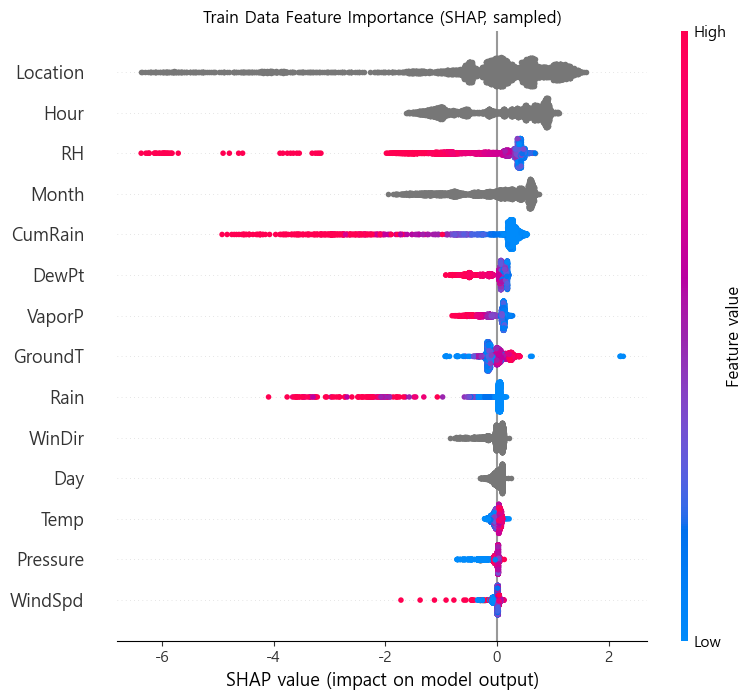

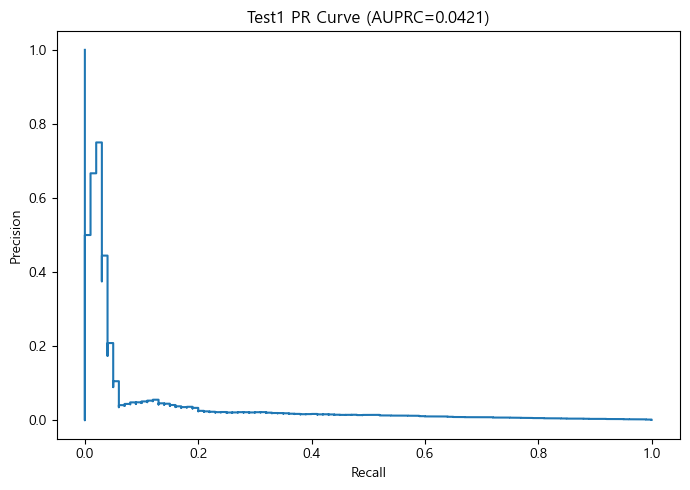

=== AUPRC ===
Train AUPRC:  0.9182
Test1 AUPRC: 0.0421


In [39]:
# SHAP 플롯 (별도)
shap.summary_plot(shap_vals, X_shap, show=False)
plt.title('Train Data Feature Importance (SHAP, sampled)')
plt.tight_layout()
plt.show()

# PR Curve (별도)
tr_proba = model.predict_proba(xtr)[:,1]
te_proba = model.predict_proba(xte)[:,1]
tr_ap = average_precision_score(ytr, tr_proba)
te_ap = average_precision_score(yte, te_proba)

prec, rec, _ = precision_recall_curve(yte, te_proba)
plt.figure(figsize=(7, 5))
plt.step(rec, prec, where='post')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Test1 PR Curve (AUPRC={te_ap:.4f})")
plt.tight_layout()
plt.show()

print("=== AUPRC ===")
print(f"Train AUPRC:  {tr_ap:.4f}")
print(f"Test1 AUPRC: {te_ap:.4f}")

In [40]:
# SHAP
shap.summary_plot(shap_vals, X_shap, show=False)
plt.title('Train Data Feature Importance (SHAP)')
plt.savefig('shap.png', dpi=150, bbox_inches='tight')
plt.close()

# PR Curve
plt.figure(figsize=(7, 5))
plt.step(rec, prec, where='post')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Test1 PR Curve (AUPRC={te_ap:.4f})")
plt.savefig('pr_curve.png', dpi=150, bbox_inches='tight')
plt.close()

In [41]:
from PIL import Image

# 이미지 로드
img1 = Image.open('shap.png')
img2 = Image.open('pr_curve.png')

# 높이 맞추기
h = max(img1.height, img2.height)
img1 = img1.resize((int(img1.width * h / img1.height), h))
img2 = img2.resize((int(img2.width * h / img2.height), h))

# 가로로 합치기
combined = Image.new('RGB', (img1.width + img2.width, h))
combined.paste(img1, (0, 0))
combined.paste(img2, (img1.width, 0))

# 저장
combined.save('combined.png')
print("저장 완료: combined.png")

저장 완료: combined.png


In [26]:
print("xtr columns:", xtr.columns.tolist())
print("cat_features:", cat_feat)

pool = Pool(xtr, ytr, cat_features=cat_feat)
print("Recognized cat indices:", pool.get_cat_feature_indices())


xtr columns: ['Location', 'Temp', 'WindSpd', 'RH', 'VaporP', 'DewPt', 'Pressure', 'GroundT', 'Rain', 'CumRain', 'WinDir', 'Month', 'Day', 'Hour']
cat_features: ['WinDir', 'Hour', 'Month', 'Day', 'Location']
Recognized cat indices: [0, 10, 11, 12, 13]


In [ ]:
==================================================
최적 하이퍼파라미터
==================================================
depth: 6
learning_rate: 0.08047664295808238
l2_leaf_reg: 0.10188056276843381
iterations: 1077

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114969 entries, 0 to 114968
Data columns (total 15 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   Location  114969 non-null  category
 1   Temp      114957 non-null  float64 
 2   WindSpd   114901 non-null  float64 
 3   RH        114861 non-null  float64 
 4   VaporP    114907 non-null  float64 
 5   DewPt     114874 non-null  float64 
 6   Pressure  114872 non-null  float64 
 7   GroundT   114892 non-null  float64 
 8   Rain      114969 non-null  float64 
 9   CumRain   114969 non-null  float64 
 10  WinDir    114969 non-null  category
 11  Wildfire  114969 non-null  int64   
 12  Month     114969 non-null  category
 13  Day       114969 non-null  category
 14  Hour      114969 non-null  category
dtypes: category(5), float64(9), int64(1)
memory usage: 9.3 MB


In [29]:
print(study.best_params)


{'depth': 9, 'learning_rate': 0.08594791975576277, 'l2_leaf_reg': 0.10159369623387572, 'iterations': 1583}


In [27]:
print(xtr.isna().sum())      # NaN 개수 체크
print(xtr.dtypes)           # dtype이 전부 float64/category인지 확인


Location     0
Temp         2
WindSpd      8
RH           3
VaporP       4
DewPt        6
Pressure    26
GroundT      9
Rain         0
CumRain      0
WinDir       0
Month        0
Day          0
Hour         0
dtype: int64
Location    category
Temp         float64
WindSpd      float64
RH           float64
VaporP       float64
DewPt        float64
Pressure     float64
GroundT      float64
Rain         float64
CumRain      float64
WinDir      category
Month       category
Day         category
Hour        category
dtype: object


최적 하이퍼파라미터
depth: 6
learning_rate: 0.056464682096646
l2_leaf_reg: 0.10074099912296439
iterations: 1649

=== Training Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.15      0.26      4871
           1       0.54      1.00      0.70      4871

    accuracy                           0.57      9742
   macro avg       0.77      0.57      0.48      9742
weighted avg       0.77      0.57      0.48      9742


=== TEST1 Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.15      0.25    100000
           1       0.00      1.00      0.00       100

    accuracy                           0.15    100100
   macro avg       0.50      0.57      0.13    100100
weighted avg       1.00      0.15      0.25    100100



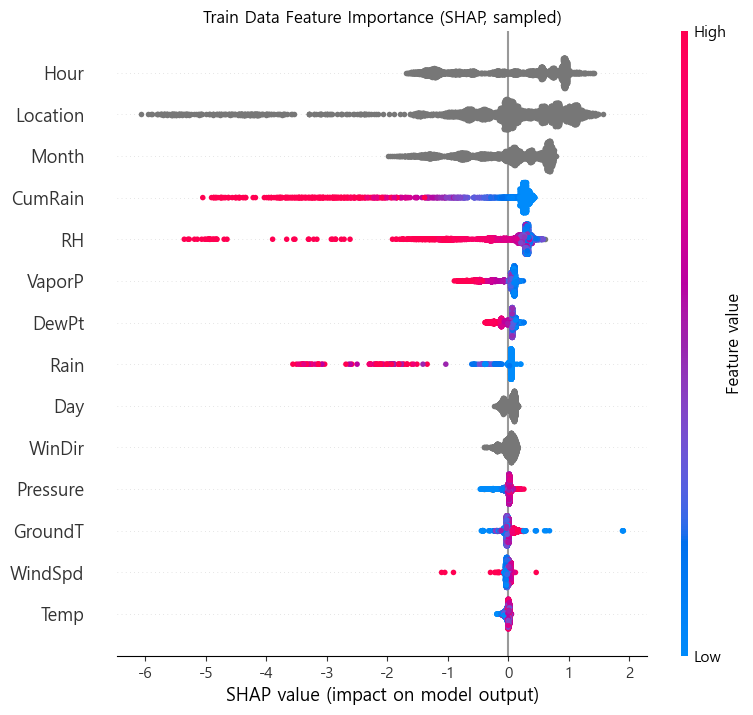

In [16]:
# 하이퍼파라미터 최적화
def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 6, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 1.0, log=True),
        'iterations': trial.suggest_int('iterations', 1000, 2000),
        'loss_function': 'Logloss',
        'verbose': 0,
        'thread_count': 6,
        'cat_features': cat_feat,
        'class_weights': [1, 2000],
        'train_dir': f'catboost_info_{trial.number}'  # 여기로 이동
    }
    
    model = CatBoostClassifier(**params)
    model.fit(xtr, ytr)
    y_pred_bin = (model.predict_proba(xtr)[:, 1] >= 0.7).astype(int)
    return f1_score(ytr, y_pred_bin)

# Optuna 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, n_jobs=2)

# 최적 모델 학습
best = study.best_params
best.update({
    'loss_function': 'Logloss',
    'verbose': 0,
    'thread_count': 8,
    'cat_features': cat_feat,
    'class_weights': [1, 2000]
})

model = CatBoostClassifier(**best)
model.fit(xtr, ytr)

# 결과 출력
print("="*50)
print("최적 하이퍼파라미터")
print("="*50)
for param, value in study.best_params.items():
    print(f"{param}: {value}")

thresh = 0.7

# 훈련 데이터 분류 리포트
print("\n=== Training Classification Report ===")
print(classification_report(
    ytr,
    (model.predict_proba(xtr)[:,1] >= thresh).astype(int)
))

# 테스트1 분류 리포트
print("\n=== TEST1 Classification Report ===")
print(classification_report(
    yte,
    (model.predict_proba(xte)[:,1] >= thresh).astype(int)
))

# SHAP 분석
n_shap = min(5000, len(xtr))
rng = np.random.RandomState(1)
idx = rng.choice(xtr.index, size=n_shap, replace=False)
X_shap = xtr.loc[idx]
y_shap = ytr.loc[idx]

# Pool 생성 (대문자 P)
pool_shap = Pool(X_shap, y_shap, cat_features=cat_feat)

# CatBoost 네이티브 SHAP
shap_vals_full = model.get_feature_importance(
    type='ShapValues',
    data=pool_shap
)
shap_vals = shap_vals_full[:, :-1]

shap.summary_plot(shap_vals, X_shap, show=False)
plt.title('Train Data Feature Importance (SHAP, sampled)')
plt.show()

=== AUPRC ===
Train AUPRC:  0.9216
Test1 AUPRC: 0.0359


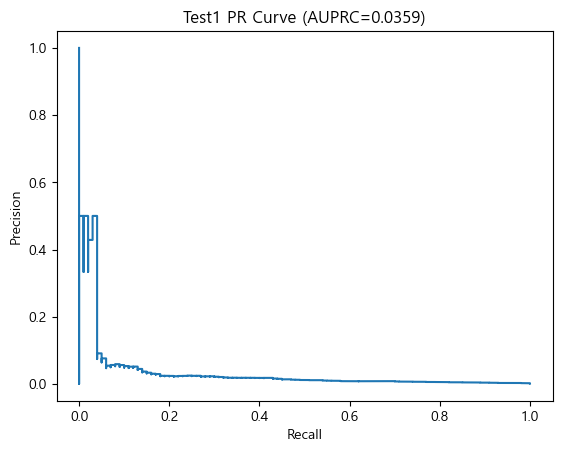

In [17]:
# 확률 예측
tr_proba = model.predict_proba(xtr)[:,1]
te_proba = model.predict_proba(xte)[:,1]

# AUPRC 계산
tr_ap = average_precision_score(ytr, tr_proba)
te_ap = average_precision_score(yte, te_proba)

print("=== AUPRC ===")
print(f"Train AUPRC:  {tr_ap:.4f}")
print(f"Test1 AUPRC: {te_ap:.4f}")

# PR 곡선 시각화 (옵션)
prec, rec, _ = precision_recall_curve(yte, te_proba)
plt.step(rec, prec, where='post')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Test1 PR Curve (AUPRC={te_ap:.4f})")
plt.show()


In [20]:
print(df.columns.tolist())
print(df['Wildfire(0/1)'].value_counts())

['Location', 'Temp (°C)', 'WindSpd (m/s)', 'RH (%)', 'VaporP (hPa)', 'DewPt (°C)', 'Pressure (hPa)', 'GroundT (°C)', 'Rain(mm)', 'CumRain(24h)', 'WinDir', 'Wildfire(0/1)', 'Month', 'Day', 'Hour']
Wildfire(0/1)
0    109998
1      4971
Name: count, dtype: int64


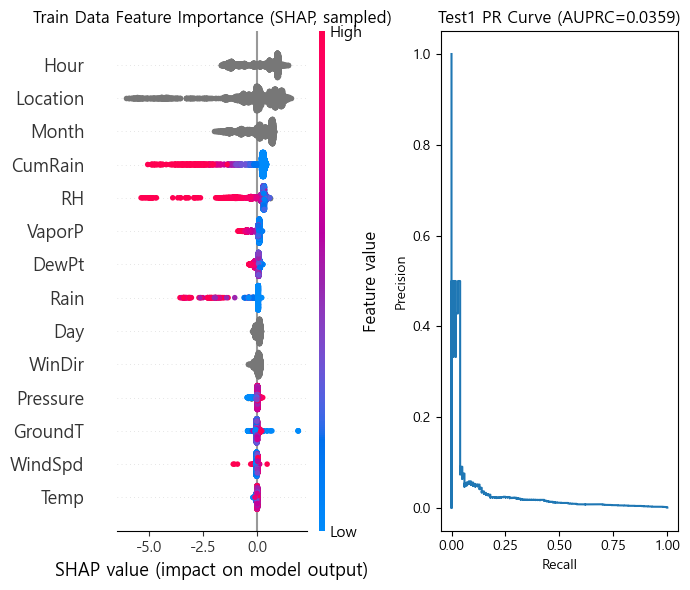

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax1, ax2 = axes

# --- (1) SHAP summary plot ---
plt.sca(ax1)
shap.summary_plot(
    shap_vals, 
    X_shap, 
    show=False, 
    plot_size=(7, 6)   # ✅ 이 한 줄만 추가!
)
ax1.set_title('Train Data Feature Importance (SHAP, sampled)')

# --- (2) PR Curve ---
tr_proba = model.predict_proba(xtr)[:, 1]
te_proba = model.predict_proba(xte)[:, 1]
tr_ap = average_precision_score(ytr, tr_proba)
te_ap = average_precision_score(yte, te_proba)

prec, rec, _ = precision_recall_curve(yte, te_proba)
ax2.step(rec, prec, where='post')
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_title(f"Test1 PR Curve (AUPRC={te_ap:.4f})")

plt.tight_layout()
plt.show()



In [21]:
# 코드 맨 위에 추가
import shutil
if os.path.exists('catboost_info'):
    shutil.rmtree('catboost_info')

NameError: name 'os' is not defined

In [22]:
print(f"Train pos: {len(tr_pos)}, neg: {len(tr_neg)}")
print(f"Test pos: {len(t1_pos)}, neg: {len(t1_neg)}")
print(f"Train 분포:\n{ytr.value_counts()}")
print(f"Test 분포:\n{yte.value_counts()}")

Train pos: 4871, neg: 4871
Test pos: 100, neg: 100000
Train 분포:
Wildfire(0/1)
0    4871
1    4871
Name: count, dtype: int64
Test 분포:
Wildfire(0/1)
0    100000
1       100
Name: count, dtype: int64


In [23]:
print(f"Train 예측 분포:\n{pd.Series((model.predict_proba(xtr)[:,1] >= 0.7).astype(int)).value_counts()}")
print(f"Test 예측 분포:\n{pd.Series((model.predict_proba(xte)[:,1] >= 0.7).astype(int)).value_counts()}")

Train 예측 분포:
1    8931
0     811
Name: count, dtype: int64
Test 예측 분포:
1    82903
0    17197
Name: count, dtype: int64


In [24]:
# 영어 코드에서
print(xtr[cat_feat].dtypes)

WinDir      category
Hour        category
Month       category
Day         category
Location    category
dtype: object


최적 하이퍼파라미터
depth: 10
learning_rate: 0.05062550346995148
l2_leaf_reg: 0.10351048624724302
iterations: 1759

=== Training Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.08      0.15      4871
           1       0.52      1.00      0.68      4871

    accuracy                           0.54      9742
   macro avg       0.76      0.54      0.42      9742
weighted avg       0.76      0.54      0.42      9742


=== TEST1 Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.08      0.15    100000
           1       0.00      1.00      0.00       100

    accuracy                           0.08    100100
   macro avg       0.50      0.54      0.08    100100
weighted avg       1.00      0.08      0.15    100100



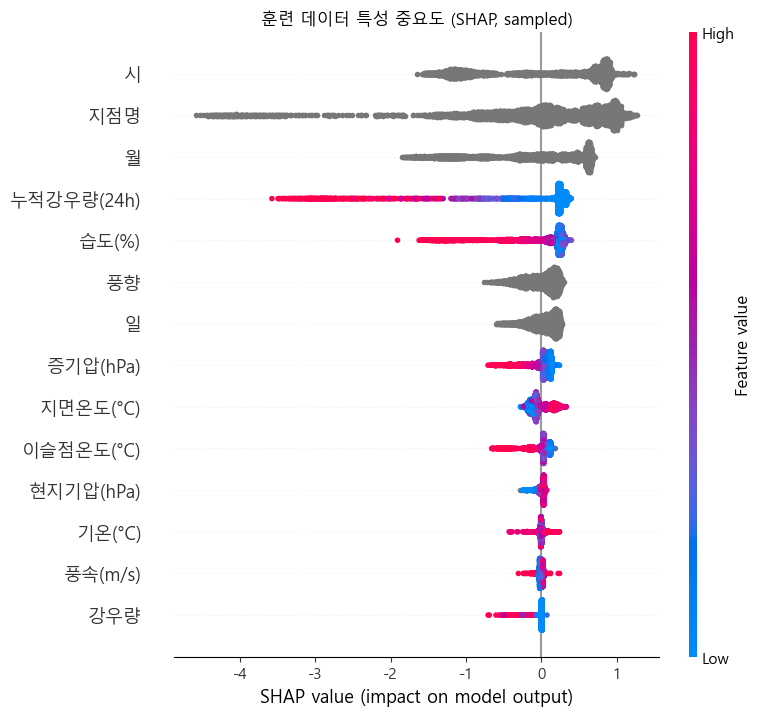

In [31]:
 start = time.time()

# 데이터 전처리
df.월 = df.월.astype('category')
df.일 = df.일.astype('category')
df.시 = df.시.astype('category') 
df.풍향 = df.풍향.astype('category')
df.지점명 = df.지점명.astype('category')

# 데이터 분할
pos = df[df['산불'] == 1]
neg = df[df['산불'] == 0]

# 훈련 데이터
tr_pos = pos.sample(n=4871, random_state=1)
tr_neg = neg.sample(n=4871, random_state=1)

# 테스트 데이터 (test1만)
pos = pos.drop(tr_pos.index)
neg = neg.drop(tr_neg.index)
t1_pos = pos.sample(n=100, random_state=1)
t1_neg = neg.sample(n=100000, random_state=1)

# 훈련/테스트 세트 생성
train = pd.concat([tr_pos, tr_neg]).sample(frac=1, random_state=1)
test1 = pd.concat([t1_pos, t1_neg]).sample(frac=1, random_state=1)
 
xtr = train.drop('산불', axis=1)
ytr = train['산불']
xte = test1.drop('산불', axis=1)
yte = test1['산불']
cat_feat = ['풍향', '시', '월','일','지점명']

# 하이퍼파라미터 최적화
def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 6, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 1.0, log=True),
        'iterations': trial.suggest_int('iterations', 1000, 2000),
        'loss_function': 'Logloss',
        'verbose': 0,
        'thread_count': 6,
        'cat_features': cat_feat,
        'class_weights': [1, 2500],
        'train_dir': f'catboost_info_{trial.number}'  # 여기로 이동
    }
    
    model = CatBoostClassifier(**params)
    model.fit(xtr, ytr)
    y_pred_bin = (model.predict_proba(xtr)[:, 1] >= 0.7).astype(int)
    return f1_score(ytr, y_pred_bin)

# Optuna 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, n_jobs=2)

# 최적 모델 학습
best = study.best_params
best.update({
    'loss_function': 'Logloss',
    'verbose': 0,
    'thread_count': 8,
    'cat_features': cat_feat,
    'class_weights': [1, 2500]
})

model = CatBoostClassifier(**best)
model.fit(xtr, ytr)

# 결과 출력
print("="*50)
print("최적 하이퍼파라미터")
print("="*50)
for param, value in study.best_params.items():
    print(f"{param}: {value}")

thresh = 0.7

# 훈련 데이터 분류 리포트
print("\n=== Training Classification Report ===")
print(classification_report(
    ytr,
    (model.predict_proba(xtr)[:,1] >= thresh).astype(int)
))

# 테스트1 분류 리포트
print("\n=== TEST1 Classification Report ===")
print(classification_report(
    yte,
    (model.predict_proba(xte)[:,1] >= thresh).astype(int)
))

# SHAP 분석
n_shap = min(5000, len(xtr))
rng = np.random.RandomState(1)
idx = rng.choice(xtr.index, size=n_shap, replace=False)
X_shap = xtr.loc[idx]
y_shap = ytr.loc[idx]

# Pool 생성 (대문자 P)
pool_shap = Pool(X_shap, y_shap, cat_features=cat_feat)

# CatBoost 네이티브 SHAP
shap_vals_full = model.get_feature_importance(
    type='ShapValues',
    data=pool_shap
)
shap_vals = shap_vals_full[:, :-1]

shap.summary_plot(shap_vals, X_shap, show=False)
plt.title('훈련 데이터 특성 중요도 (SHAP, sampled)')
plt.show()


=== AUPRC ===
Train AUPRC:  0.9286
Test1 AUPRC: 0.0187


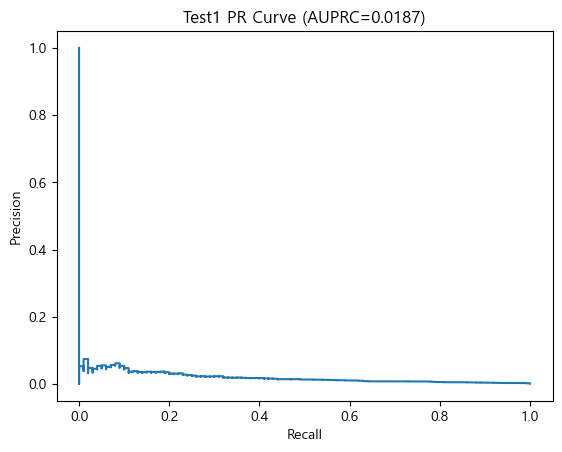

In [32]:
# 확률 예측
tr_proba = model.predict_proba(xtr)[:,1]
te_proba = model.predict_proba(xte)[:,1]

# AUPRC 계산
tr_ap = average_precision_score(ytr, tr_proba)
te_ap = average_precision_score(yte, te_proba)

print("=== AUPRC ===")
print(f"Train AUPRC:  {tr_ap:.4f}")
print(f"Test1 AUPRC: {te_ap:.4f}")

# PR 곡선 시각화 (옵션)
prec, rec, _ = precision_recall_curve(yte, te_proba)
plt.step(rec, prec, where='post')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Test1 PR Curve (AUPRC={te_ap:.4f})")
plt.show()

최적 하이퍼파라미터
depth: 6
learning_rate: 0.06681837499008128
l2_leaf_reg: 0.10218266232678004
iterations: 1716

=== Training Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.07      0.13      4871
           1       0.52      1.00      0.68      4871

    accuracy                           0.53      9742
   macro avg       0.76      0.53      0.40      9742
weighted avg       0.76      0.53      0.40      9742


=== TEST1 Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.07      0.14    100000
           1       0.00      1.00      0.00       100

    accuracy                           0.07    100100
   macro avg       0.50      0.54      0.07    100100
weighted avg       1.00      0.07      0.14    100100



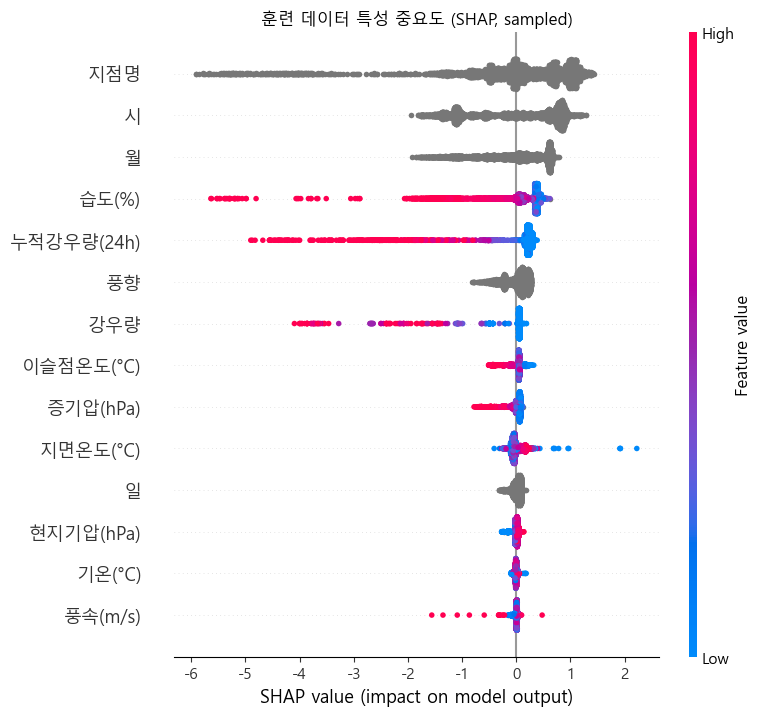

In [23]:
start = time.time()

# 데이터 전처리
df.월 = df.월.astype('category')
df.일 = df.일.astype('category')
df.시 = df.시.astype('category') 
df.풍향 = df.풍향.astype('category')
df.지점명 = df.지점명.astype('category')

# 데이터 분할
pos = df[df['산불'] == 1]
neg = df[df['산불'] == 0]

# 훈련 데이터
tr_pos = pos.sample(n=4871, random_state=1)
tr_neg = neg.sample(n=4871, random_state=1)

# 테스트 데이터 (test1만)
pos = pos.drop(tr_pos.index)
neg = neg.drop(tr_neg.index)
t1_pos = pos.sample(n=100, random_state=1)
t1_neg = neg.sample(n=100000, random_state=1)

# 훈련/테스트 세트 생성
train = pd.concat([tr_pos, tr_neg]).sample(frac=1, random_state=1)
test1 = pd.concat([t1_pos, t1_neg]).sample(frac=1, random_state=1)
 
xtr = train.drop('산불', axis=1)
ytr = train['산불']
xte = test1.drop('산불', axis=1)
yte = test1['산불']
cat_feat = ['풍향', '시', '월','일','지점명']

# 하이퍼파라미터 최적화
def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 6, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 1.0, log=True),
        'iterations': trial.suggest_int('iterations', 1000, 2000),
        'loss_function': 'Logloss',
        'verbose': 0,
        'thread_count': 6,
        'cat_features': cat_feat,
        'class_weights': [1, 2000],
        'train_dir': f'catboost_info_{trial.number}'  # 여기로 이동
    }
    
    model = CatBoostClassifier(**params)
    model.fit(xtr, ytr)
    y_pred_bin = (model.predict_proba(xtr)[:, 1] >= 0.3).astype(int)
    return f1_score(ytr, y_pred_bin)

# Optuna 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, n_jobs=2)

# 최적 모델 학습
best = study.best_params
best.update({
    'loss_function': 'Logloss',
    'verbose': 0,
    'thread_count': 8,
    'cat_features': cat_feat,
    'class_weights': [1, 2000]
})

model = CatBoostClassifier(**best)
model.fit(xtr, ytr)

# 결과 출력
print("="*50)
print("최적 하이퍼파라미터")
print("="*50)
for param, value in study.best_params.items():
    print(f"{param}: {value}")

thresh = 0.3

# 훈련 데이터 분류 리포트
print("\n=== Training Classification Report ===")
print(classification_report(
    ytr,
    (model.predict_proba(xtr)[:,1] >= thresh).astype(int)
))

# 테스트1 분류 리포트
print("\n=== TEST1 Classification Report ===")
print(classification_report(
    yte,
    (model.predict_proba(xte)[:,1] >= thresh).astype(int)
))

# SHAP 분석
n_shap = min(5000, len(xtr))
rng = np.random.RandomState(1)
idx = rng.choice(xtr.index, size=n_shap, replace=False)
X_shap = xtr.loc[idx]
y_shap = ytr.loc[idx]

# Pool 생성 (대문자 P)
pool_shap = Pool(X_shap, y_shap, cat_features=cat_feat)

# CatBoost 네이티브 SHAP
shap_vals_full = model.get_feature_importance(
    type='ShapValues',
    data=pool_shap
)
shap_vals = shap_vals_full[:, :-1]

shap.summary_plot(shap_vals, X_shap, show=False)
plt.title('훈련 데이터 특성 중요도 (SHAP, sampled)')
plt.show()

=== AUPRC ===
Train AUPRC:  0.9217
Test1 AUPRC: 0.0258


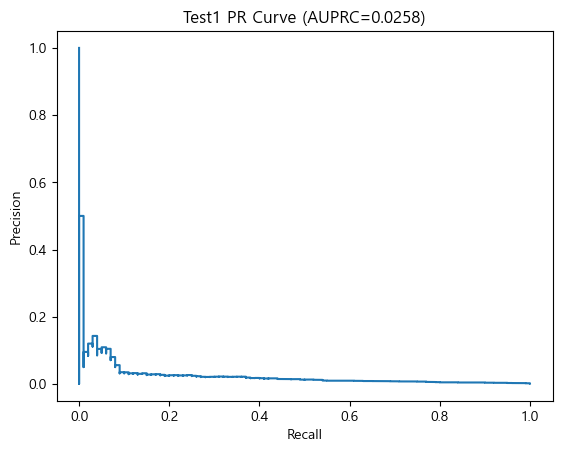

In [24]:
tr_proba = model.predict_proba(xtr)[:,1]
te_proba = model.predict_proba(xte)[:,1]

# AUPRC 계산
tr_ap = average_precision_score(ytr, tr_proba)
te_ap = average_precision_score(yte, te_proba)

print("=== AUPRC ===")
print(f"Train AUPRC:  {tr_ap:.4f}")
print(f"Test1 AUPRC: {te_ap:.4f}")

# PR 곡선 시각화 (옵션)
prec, rec, _ = precision_recall_curve(yte, te_proba)
plt.step(rec, prec, where='post')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Test1 PR Curve (AUPRC={te_ap:.4f})")
plt.show()


최적 하이퍼파라미터
depth: 8
learning_rate: 0.08746112424448343
l2_leaf_reg: 0.10179957676510665
iterations: 1877

=== Training Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.09      0.16      4871
           1       0.52      1.00      0.69      4871

    accuracy                           0.54      9742
   macro avg       0.76      0.54      0.42      9742
weighted avg       0.76      0.54      0.42      9742


=== TEST1 Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.09      0.17    100000
           1       0.00      1.00      0.00       100

    accuracy                           0.09    100100
   macro avg       0.50      0.55      0.09    100100
weighted avg       1.00      0.09      0.17    100100



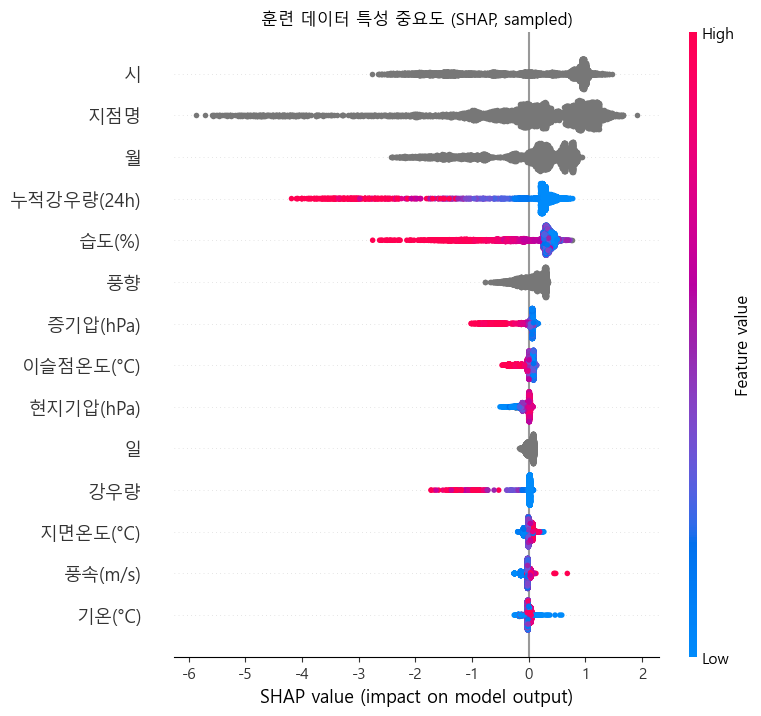

In [25]:
start = time.time()

# 데이터 전처리
df.월 = df.월.astype('category')
df.일 = df.일.astype('category')
df.시 = df.시.astype('category') 
df.풍향 = df.풍향.astype('category')
df.지점명 = df.지점명.astype('category')

# 데이터 분할
pos = df[df['산불'] == 1]
neg = df[df['산불'] == 0]

# 훈련 데이터
tr_pos = pos.sample(n=4871, random_state=1)
tr_neg = neg.sample(n=4871, random_state=1)

# 테스트 데이터 (test1만)
pos = pos.drop(tr_pos.index)
neg = neg.drop(tr_neg.index)
t1_pos = pos.sample(n=100, random_state=1)
t1_neg = neg.sample(n=100000, random_state=1)

# 훈련/테스트 세트 생성
train = pd.concat([tr_pos, tr_neg]).sample(frac=1, random_state=1)
test1 = pd.concat([t1_pos, t1_neg]).sample(frac=1, random_state=1)
 
xtr = train.drop('산불', axis=1)
ytr = train['산불']
xte = test1.drop('산불', axis=1)
yte = test1['산불']
cat_feat = ['풍향', '시', '월','일','지점명']

# 하이퍼파라미터 최적화
def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 6, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 1.0, log=True),
        'iterations': trial.suggest_int('iterations', 1000, 2000),
        'loss_function': 'Logloss',
        'verbose': 0,
        'thread_count': 6,
        'cat_features': cat_feat,
        'class_weights': [1, 500],
        'train_dir': f'catboost_info_{trial.number}'  # 여기로 이동
    }
    
    model = CatBoostClassifier(**params)
    model.fit(xtr, ytr)
    y_pred_bin = (model.predict_proba(xtr)[:, 1] >= 0.3).astype(int)
    return f1_score(ytr, y_pred_bin)

# Optuna 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, n_jobs=2)

# 최적 모델 학습
best = study.best_params
best.update({
    'loss_function': 'Logloss',
    'verbose': 0,
    'thread_count': 8,
    'cat_features': cat_feat,
    'class_weights': [1, 2000]
})

model = CatBoostClassifier(**best)
model.fit(xtr, ytr)

# 결과 출력
print("="*50)
print("최적 하이퍼파라미터")
print("="*50)
for param, value in study.best_params.items():
    print(f"{param}: {value}")

thresh = 0.3

# 훈련 데이터 분류 리포트
print("\n=== Training Classification Report ===")
print(classification_report(
    ytr,
    (model.predict_proba(xtr)[:,1] >= thresh).astype(int)
))

# 테스트1 분류 리포트
print("\n=== TEST1 Classification Report ===")
print(classification_report(
    yte,
    (model.predict_proba(xte)[:,1] >= thresh).astype(int)
))

# SHAP 분석
n_shap = min(5000, len(xtr))
rng = np.random.RandomState(1)
idx = rng.choice(xtr.index, size=n_shap, replace=False)
X_shap = xtr.loc[idx]
y_shap = ytr.loc[idx]

# Pool 생성 (대문자 P)
pool_shap = Pool(X_shap, y_shap, cat_features=cat_feat)

# CatBoost 네이티브 SHAP
shap_vals_full = model.get_feature_importance(
    type='ShapValues',
    data=pool_shap
)
shap_vals = shap_vals_full[:, :-1]

shap.summary_plot(shap_vals, X_shap, show=False)
plt.title('훈련 데이터 특성 중요도 (SHAP, sampled)')
plt.show()

=== AUPRC ===
Train AUPRC:  0.9170
Test1 AUPRC: 0.0338


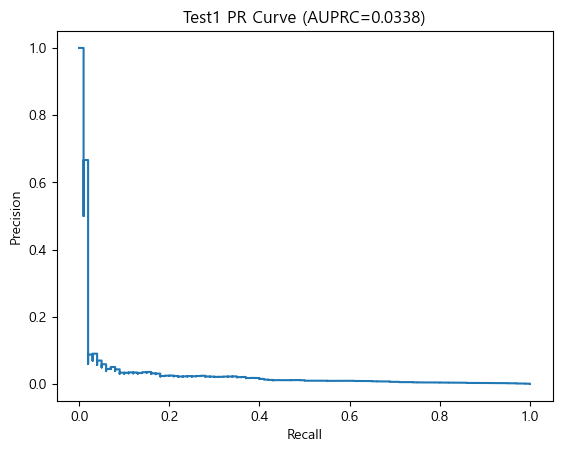

In [26]:
tr_proba = model.predict_proba(xtr)[:,1]
te_proba = model.predict_proba(xte)[:,1]

# AUPRC 계산
tr_ap = average_precision_score(ytr, tr_proba)
te_ap = average_precision_score(yte, te_proba)

print("=== AUPRC ===")
print(f"Train AUPRC:  {tr_ap:.4f}")
print(f"Test1 AUPRC: {te_ap:.4f}")

# PR 곡선 시각화 (옵션)
prec, rec, _ = precision_recall_curve(yte, te_proba)
plt.step(rec, prec, where='post')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Test1 PR Curve (AUPRC={te_ap:.4f})")
plt.show()


In [55]:
ct = pd.crosstab(df['풍향'], df['산불'])

# 카이제곱 독립성 검정
chi2, p, dof, expected = stats.chi2_contingency(ct)

# 표본 수
n = ct.to_numpy().sum()

# 최소 차원 선택 (행/열 중 작은 값 - 1)
k = min(ct.shape) - 1

# Cramer's V 계산
cramers_v = np.sqrt(chi2 / (n * k))

print("Chi2 통계량:", chi2)
print("p-value:", p)
print("Cramer's V:", cramers_v)


Chi2 통계량: 1041.1700804211798
p-value: 1.7047816592578524e-211
Cramer's V: 0.09516351234163946


In [63]:
df['서풍여부'] = df['풍향'].str.contains('서')

In [64]:
ct3 = pd.crosstab(df['서풍여부'], df['산불'])

In [65]:
stats.chi2_contingency(ct3)

Chi2ContingencyResult(statistic=np.float64(715.466302894385), pvalue=np.float64(1.2957072821251924e-157), dof=1, expected_freq=array([[60075.10215797,  2714.89784203],
       [49922.89784203,  2256.10215797]]))

In [66]:
from scipy.stats import fisher_exact

oddsratio, p_fisher = fisher_exact(ct3)
print("오즈비:", oddsratio)
print("Fisher p-value:", p_fisher)


오즈비: 2.200356150191094
Fisher p-value: 9.47531308775639e-158


In [68]:
df['서풍여부'] = df['풍향'].str.contains('서').astype(int)

In [69]:
ct2 = pd.crosstab(df['서풍여부'], df['산불'])

rate_west = ct2.loc[1,1] / ct2.loc[1].sum() * 100
rate_non  = ct2.loc[0,1] / ct2.loc[0].sum() * 100

print(f"서풍일 때 산불 발생률: {rate_west:.2f}%")
print(f"비서풍일 때 산불 발생률: {rate_non:.2f}%")


서풍일 때 산불 발생률: 6.08%
비서풍일 때 산불 발생률: 2.86%


In [71]:
df.지점명.nunique()

98